## Word embedding
Word embeddings are dense vector representations of words in a continuous vector space, where semantically similar words are mapped to nearby points. Unlike one-hot encoding, which represents words as sparse vectors with high dimensionality, word embeddings capture syntactic and semantic relationships between words in a lower-dimensional space.

Mathematically, given a vocabulary of size $V$, each word $w_i$ is represented as a vector $\mathbf{v}_i \in \mathbb{R}^d$, where $d \ll V$. The embedding matrix $\mathbf{E} \in \mathbb{R}^{V \times d}$ contains all word vectors as its rows.

Popular methods for learning word embeddings include:

- **Word2Vec**: Optimizes the probability of context words given a target word (Skip-gram) or the target word given context words (CBOW). For Skip-gram, the objective is to maximize:
    $$
    \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq j \leq c, j \neq 0} \log p(w_{t+j} \mid w_t)
    $$
    where $c$ is the context window size.

- **GloVe**: Learns embeddings by factorizing the word co-occurrence matrix. The objective is to minimize:
    $$
    J = \sum_{i,j=1}^{V} f(X_{ij}) \left( \mathbf{v}_i^\top \mathbf{\tilde{v}}_j + b_i + \tilde{b}_j - \log X_{ij} \right)^2
    $$
    where $X_{ij}$ is the co-occurrence count of words $i$ and $j$, and $f$ is a weighting function.

Word embeddings enable models to generalize better and perform well on various natural language processing tasks by capturing the underlying structure and meaning of language.

In [467]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions.uniform import Uniform

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns


## One-Hot Encoding for Training Data

Let's perform one-hot encoding for the sentences:

- "Troll2 is great!"
- "Gymkata"

### Step 1: Build the Vocabulary

First, extract the unique words from both sentences:

- "Troll2"
- "is"
- "great!"
- "Gymkata"

Vocabulary:  

`['Troll2', 'is', 'great!', 'Gymkata']`

### Step 2: Assign One-Hot Vectors

Each word is represented by a vector of length 4 (since there are 4 unique words):

| Word      | One-Hot Vector    |
|-----------|-------------------|
| Troll2    | [1, 0, 0, 0]      |
| is        | [0, 1, 0, 0]      |
| great!    | [0, 0, 1, 0]      |
| Gymkata   | [0, 0, 0, 1]      |

### Step 3: Encode the Sentences

- "Troll2 is great!":  
    `[1, 0, 0, 0]` (Troll2)  
    `[0, 1, 0, 0]` (is)  
    `[0, 0, 1, 0]` (great!)

- "Gymkata":  
    `[0, 0, 0, 1]` (Gymkata)

In [468]:
from sklearn.preprocessing import OneHotEncoder

sentences = [["Troll2", "is", "great!"], ["Gymkata", "is", "great!"]]

# Flatten to get all unique words
vocab = sorted(set(word for sent in sentences for word in sent))

# Prepare data for OneHotEncoder
data = []
for sent in sentences:
    data.extend([[word] for word in sent])

encoder = OneHotEncoder(categories=[vocab], sparse_output=False)
import numpy as np
encoder.fit(np.array(data))

import numpy as np

# Encode each sentence
encoded_sentences = [encoder.transform(np.array([[word] for word in sent])) for sent in sentences]

for i, sent in enumerate(sentences):
    print(f"Sentence: {' '.join(sent)}")
    print(encoded_sentences[i])

Sentence: Troll2 is great!
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Sentence: Gymkata is great!
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [469]:
vocab

['Gymkata', 'Troll2', 'great!', 'is']

In [470]:
encoded_sentences

[array([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])]

In [471]:
# Convert encoded_sentences into torch tensors and concatenate for dataset

# Flatten encoded_sentences into a single array for all words
all_encoded = torch.tensor(
    [vec for sent in encoded_sentences for vec in sent], dtype=torch.float32
)

# Example: dummy targets (e.g., all zeros, or use your own targets)
targets = torch.zeros(len(all_encoded), dtype=torch.long)

# Create TensorDataset and DataLoader
dataset = TensorDataset(all_encoded, targets)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Example: iterate through the dataloader
for batch_x, batch_y in dataloader:
    print(batch_x, batch_y)

tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.]]) tensor([0, 0])
tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.]]) tensor([0, 0])
tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.]]) tensor([0, 0])


In [472]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [473]:
all_encoded

tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])

In [474]:
class WordEmbeddingScratch(L.LightningModule):
    def __init__(self, vocab_size=len(vocab), embed_dim=2):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Embedding matrix as a learnable parameter
        self.embedding = nn.Parameter(
            Uniform(-0.5, 0.5).sample((vocab_size, embed_dim))
        )
    
    def forward(self, input):
        # input: one-hot vectors, shape (batch_size, vocab_size)
        # embedding: (vocab_size, embed_dim)
        # output: (batch_size, embed_dim)
        return input @ self.embedding
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        emb = self.forward(x)
        # Example loss: L2 norm of embeddings (for demonstration)
        loss = torch.norm(emb)
        self.log("train_loss", loss)
        return loss


In [475]:
model = WordEmbeddingScratch()

In [476]:
for name, param in model.named_parameters():
    print(f'before optimization, parameter {name} is:\n{param.data}')

before optimization, parameter embedding is:
tensor([[ 0.4874, -0.0316],
        [-0.4759,  0.0929],
        [ 0.2836,  0.0254],
        [-0.4964,  0.0381]])


In [477]:
embedding_df = pd.DataFrame(param.data.numpy(), index=vocab, columns=[f"dim_{i}" for i in range(param.data.shape[1])])
embedding_df

,dim_0,dim_1
Gymkata,0.487424,-0.031631
Troll2,-0.475868,0.092907
great!,0.283612,0.025412
is,-0.496423,0.038072


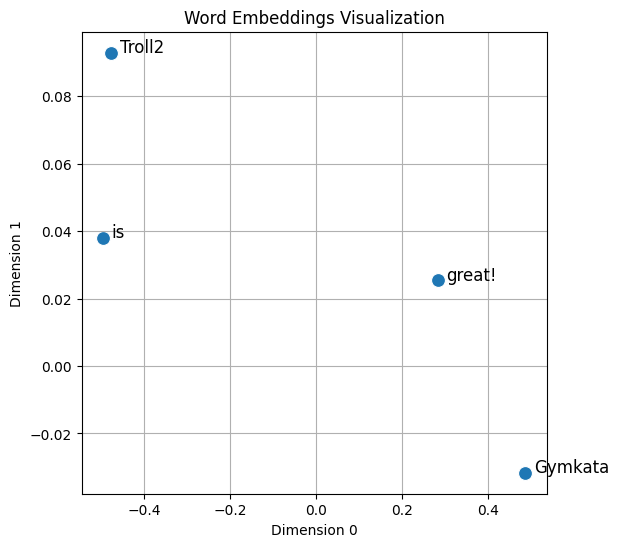

In [478]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="dim_0", y="dim_1", data=embedding_df, s=100
)

for word, row in embedding_df.iterrows():
    plt.text(float(row["dim_0"]) + 0.02, float(row["dim_1"]), str(word), fontsize=12)

plt.title("Word Embeddings Visualization")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.grid(True)
plt.show()

In [479]:
trainer = L.Trainer(max_epochs=200)
trainer.fit(model,train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 8      | n/a 
---------------------------------------------
8         Trainable params
0         Non-trainable params
8         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/bishwashchaudhari/quests/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/bishwashchaudhari/quests/ve

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 206.46it/s, v_num=30]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 174.06it/s, v_num=30]


In [480]:
embedding_df = pd.DataFrame(model.embedding.data.numpy(), index=vocab, columns=[f"dim_{i}" for i in range(model.embedding.data.shape[1])])
embedding_df


,dim_0,dim_1
Gymkata,-0.000205,-0.062729
Troll2,0.022924,-0.007418
great!,0.004835,-0.000361
is,-0.008390,-0.029940


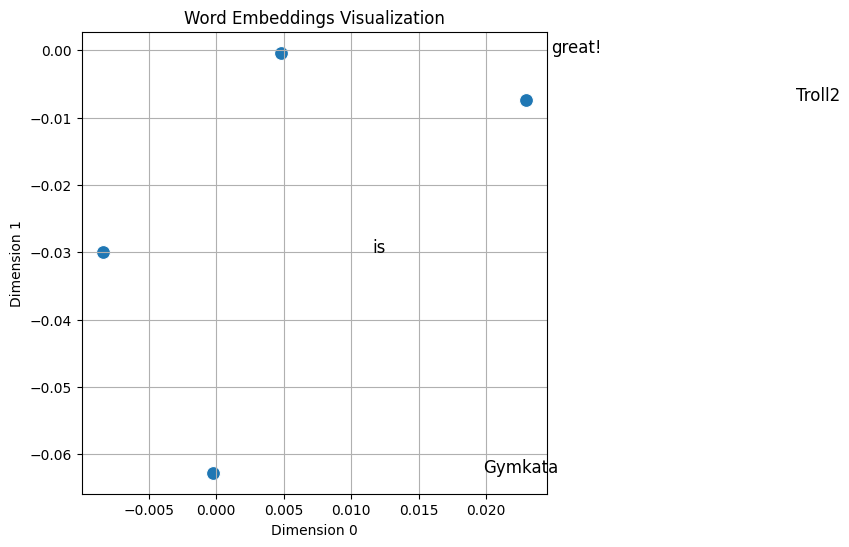

In [481]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="dim_0", y="dim_1", data=embedding_df, s=100
)

for word, row in embedding_df.iterrows():
    plt.text(float(row["dim_0"]) + 0.02, float(row["dim_1"]), str(word), fontsize=12)

plt.title("Word Embeddings Visualization")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.grid(True)
plt.show()

In [482]:
softmax = nn.Softmax(dim=0)
print(torch.round(softmax(model(all_encoded))))


tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<RoundBackward0>)


## With PyTorch Linear()

In [483]:
class WordEmbeddingLinear(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input):
        hidden = self.input_to_hidden(input)
        output_values = self.hidden_to_output(hidden)
        return output_values
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self,batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i,label_i)
        return loss
        
        
        

In [484]:
modellinear = WordEmbeddingLinear()

data = {
    'w1': modellinear.input_to_hidden.weight.detach()[0].numpy(),
    'w2': modellinear.input_to_hidden.weight.detach()[1].numpy(),
    
    'token':["Troll2",'is','great','Gymkata'],
    "input":['input1','input2','input3', 'input4']
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.185975,-0.152913,Troll2,input1
1,0.010450,0.441812,is,input2
2,-0.145409,-0.017726,great,input3
3,0.485694,0.250518,Gymkata,input4


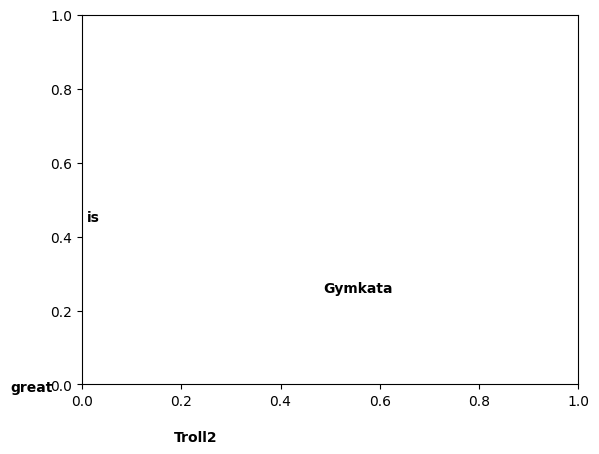

In [485]:
for idx in range(len(df)):
    plt.text(df.w1[idx], df.w2[idx], df.token[idx],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()

In [486]:
trainer = L.Trainer(max_epochs=600)
trainer.fit(modellinear,train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/bishwashchaudhari/quests/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers whi

Epoch 599: 100%|██████████| 3/3 [00:00<00:00, 295.10it/s, v_num=31]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 3/3 [00:00<00:00, 208.35it/s, v_num=31]


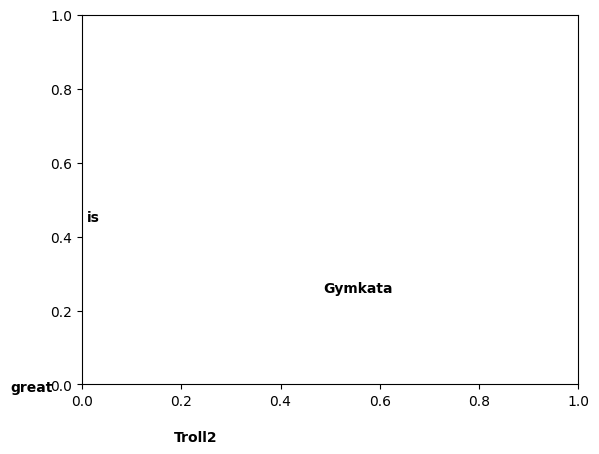

In [487]:
for idx in range(len(df)):
    plt.text(df.w1[idx], df.w2[idx], df.token[idx],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()

In [488]:
modellinear.input_to_hidden.weight

Parameter containing:
tensor([[ 1.9936,  1.8997,  2.1067,  2.3762],
        [ 0.4555,  1.0808,  0.4418, -0.1734]], requires_grad=True)

## Using Pretrained WordEmbedding

In [489]:
word_embeddings = nn.Embedding.from_pretrained(modellinear.input_to_hidden.weight.T)

In [490]:
word_embeddings.weight

Parameter containing:
tensor([[ 1.9936,  0.4555],
        [ 1.8997,  1.0808],
        [ 2.1067,  0.4418],
        [ 2.3762, -0.1734]])

In [491]:
word_embeddings(torch.tensor(0))

tensor([1.9936, 0.4555])

In [492]:
vocab = {
    'Troll2':0,
    'is':1,
    'great':2,
    'Gymkata':3
}

In [493]:
word_embeddings(torch.tensor(vocab['Troll2']))

tensor([1.9936, 0.4555])

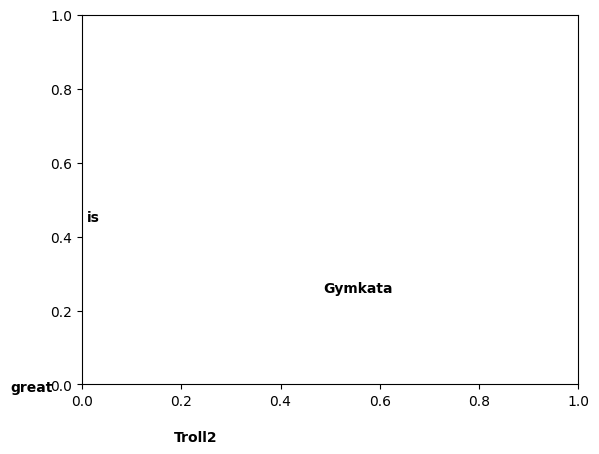

In [494]:
for idx in range(len(df)):
    plt.text(df.w1[idx], df.w2[idx], df.token[idx],
             horizontalalignment='left',
             size='medium',
             color='black',
             weight='semibold')
plt.show()